In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import matplotlib.pyplot as plt


In [21]:
X, Y, Z = np.loadtxt("test.csv", delimiter=',', skiprows=1).T
dx, dy = np.diff(np.sort(np.unique(X)))[0], np.diff(np.sort(np.unique(Y)))[0]
nx, ny = int((X.max() - X.min())//dx) + 1, int((Y.max() - Y.min())//dy) + 1

X, Y, Z = X.reshape(nx, ny), Y.reshape(nx, ny), Z.reshape(nx, ny)

In [52]:

data = pd.read_csv("testnetwork.csv")
data["Node"] = np.arange(data.shape[0])

reaches = [shapely.LineString()]*data.shape[0]
for i in range(data.shape[0]):
    if data["DownNode"][i] >= 0:
        reaches[i] = shapely.LineString([
            (data["X"][i], data["Y"][i]),#, z[node[i]]),
            (data["X"][data["DownNode"][i]], data["Y"][data["DownNode"][i]]),#, z[downnode[i]])
        ])
watershed=gpd.GeoDataFrame(data, geometry=reaches)

watershed["TWI"] = np.log(watershed["A"]/watershed["slope"])

watershed.head()


,X,Y,Z,A,slope,toSC,toCM,toRN,perm,leng,DownNode,Node,geometry,TWI
0,0.5,0.5,78.805496,1,20.0,0,0,0,309,1.414214,41,0,"LINESTRING (0.50000 0.50000, 1.50000 1.50000)",-2.995732
1,0.5,1.5,68.805496,1,20.0,1,0,1,268,1.414214,42,1,"LINESTRING (0.50000 1.50000, 1.50000 2.50000)",-2.995732
2,0.5,2.5,60.521225,1,20.0,2,0,2,270,1.000000,42,2,"LINESTRING (0.50000 2.50000, 1.50000 2.50000)",-2.995732
3,0.5,3.5,68.805496,1,20.0,3,0,3,269,1.414214,42,3,"LINESTRING (0.50000 3.50000, 1.50000 2.50000)",-2.995732
4,0.5,4.5,76.711434,1,20.0,4,0,4,229,1.414214,45,4,"LINESTRING (0.50000 4.50000, 1.50000 5.50000)",-2.995732


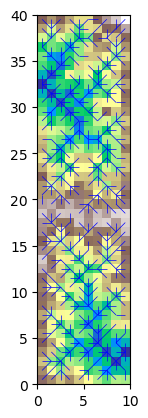

In [55]:
# norm = plt.Normalize(watershed["Z"].min(), watershed["Z"].max())
# color = plt.colormaps["terrain"](norm(watershed["Z"]))
ax = watershed.plot(color="blue", lw=0.5)
ax.pcolormesh(X, Y, Z, cmap="terrain")

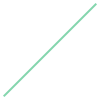

In [22]:
df = watershed.query("toCM == 0").copy()
outlet = df.loc[~df["DownNode"].isin(df["Node"]), "Node"].iloc[0]
df[df["Node"] == 253].geometry.iloc[0]

In [39]:
class MyNetwork():
    def __init__(self, df:gpd.GeoDataFrame, outlet=None, parent=None):
        if outlet is None:
            outlet = df.loc[~df["DownNode"].isin(df["Node"]), "Node"].iloc[0]
        
        reach_properties = df[df["Node"] == outlet]
        self.properties = {
            "A":reach_properties.A.iloc[0],
            "slope":reach_properties.slope.iloc[0],
            "leng":reach_properties.leng.iloc[0],
        }
        
        self.geometry = reach_properties.geometry.iloc[0]
        
        self.parent = parent
        
        child_nodes = df["Node"][df["DownNode"] == outlet].values
        self.children = [MyNetwork(df, outlet=n, parent=self) for n in child_nodes]

        self.headwaters = self.leaves()
    
    def leaves(self):
        leaf_lst = []
        def _leaves(node):
            if node is not None:
                if len(node.children) == 0:
                    leaf_lst.append(node)
                for n in node.children:
                    _leaves(n)
        _leaves(self)
        return leaf_lst

network = MyNetwork(watershed.query("toCM == 0").copy())